In [1]:
import h5py # type: ignore
import numpy as np # type: ignore
import matplotlib.pyplot as plt # type: ignore
import os
import sounddevice as sd # type: ignore
from pathlib import Path
import tensorflow as tf # type: ignore
import acoular as ac
import matplotlib.pyplot as plt # type: ignore
import matplotlib # type: ignore


2024-10-18 17:41:38.390275: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-18 17:41:38.390303: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-18 17:41:38.391115: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-18 17:41:38.396334: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/rabea/micromamba/envs/ba_a/li

In [2]:
results_folder = 'messungen/'

result_list = os.listdir(results_folder)

print("Anzahl an Ergebnissen:", len(result_list)/2)

test_result = result_list[-2]
test_samples = result_list[-1]

print(test_samples, test_result)

Anzahl an Ergebnissen: 2.0
2024-10-17_14-50-30_model_time_data.h5 2024-10-17_14-50-30_model_results.h5


In [3]:
result_filename_long = "messungen/2024-10-17_14-50-30_model_results.h5"
sample_filename_long = "messungen/2024-10-17_14-50-30_model_time_data.h5"

result_filename = "messungen/2024-10-17_14-53-06_model_results.h5"
sample_filename = "messungen/2024-10-17_14-53-06_model_time_data.h5"

channel_index = 0

num_time_samples = 5000  

Shape von 'time_data': (311296, 16)
Abtastrate: 44100.0 Hz


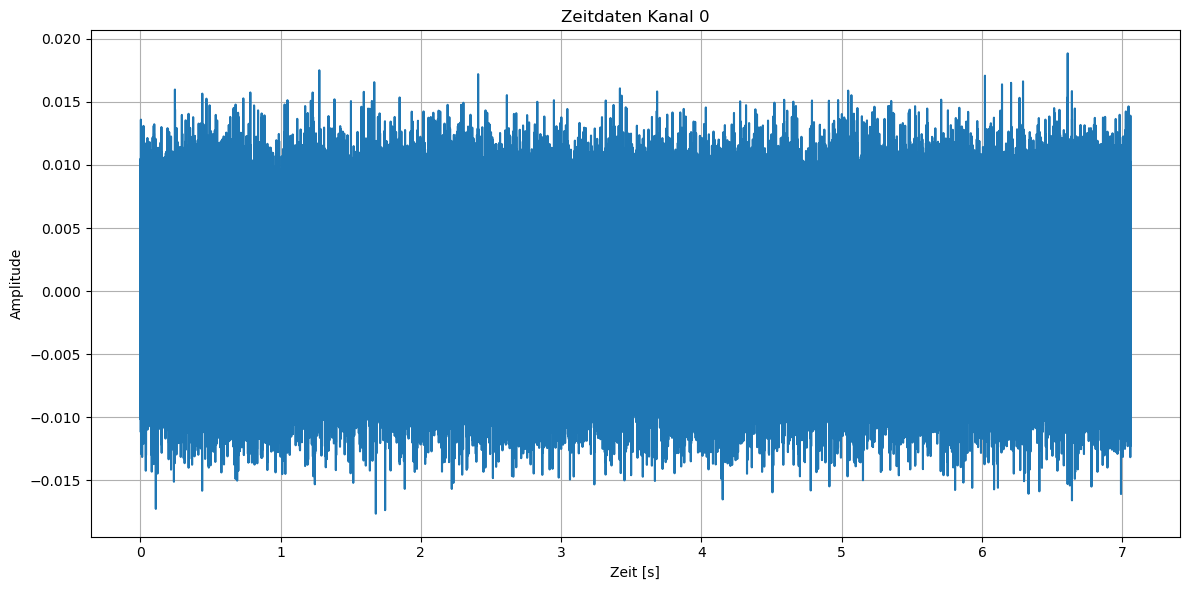

In [4]:
with h5py.File(sample_filename, 'r') as hdf5_file:

    time_data = hdf5_file['time_data']
    sample_freq = time_data.attrs['sample_freq']

    print(f"Shape von 'time_data': {time_data.shape}")
    print(f"Abtastrate: {sample_freq} Hz")
    
    channel_data = time_data[:, channel_index]
    
    num_samples = min(num_time_samples, channel_data.shape[0])
    time_vector = np.arange(len(channel_data)) / sample_freq
    
    plt.figure(figsize=(12, 6))
    plt.plot(time_vector, channel_data)
    plt.xlabel('Zeit [s]')
    plt.ylabel('Amplitude')
    plt.title(f'Zeitdaten Kanal {channel_index}')
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    

In [5]:
def recover_loc(loc, aperture, shift_loc=True, norm_loc=2):
        
    if shift_loc:
        if isinstance(shift_loc, float):
            loc = loc - shift_loc
        else:
            loc = loc - 0.5
    if norm_loc:
        if isinstance(norm_loc, float):
            loc = loc * norm_loc
        else:
            loc = loc * aperture
    return loc


In [6]:
def _preprocess_csm(csm_shape, data, dev, f_ind, ref_mic_index=0):
    """ Preprocess the CSM data
    """
    # will not be necessary, as soon as MsskedSpectraInOut is implemented
    csm = np.real(data).reshape(csm_shape) #P2
    print(csm.shape)
    #csm = np.real(data).reshape(len(data)/(16*16), 16, 16)
    csm = csm[f_ind].reshape(dev.numchannels, dev.numchannels) #P2
    
    # at this point, the CSM is in [Volt^2] since the microphone channel data
    # is a voltage strea -> we need to convert it to squared sound pressure values [Pa^2]
    # we do not account for the true sensitivity of the MEMS microphones here! 
    # I just use a standard sensitivity of 16 mV/Pa for all microphones
    # MEMS Sensitivity (94 dB SPL @ 1 kHz) -29 dBFS -> TODO?
    csm = csm / 0.0016**2

    # Normalization of the CSM with respect to the reference microphone
    csm_norm = csm[ref_mic_index, ref_mic_index]
    csm = csm / csm_norm

    csm = csm.reshape(1, 16, 16)

    # Preprocessing
    neig = 8
    evls, evecs = np.linalg.eigh(csm)
    eigmode = evecs[..., -neig:] * evls[:, np.newaxis, -neig:]
    eigmode = np.stack([np.real(eigmode), np.imag(eigmode)], axis=3)
    eigmode = np.transpose(eigmode, [0, 2, 1, 3])
    input_shape = np.shape(eigmode)
    eigmode = np.reshape(eigmode, [-1, input_shape[1], input_shape[2]*input_shape[3]])

    return eigmode, csm_norm

In [7]:
model_name = "EigmodeTransformer_learning_rate0.00025_weight_decay1e-06_epochs500_2024-10-16_16-51"
model_dir = Path(f"/home/rabea/Documents/Bachelorarbeit/models/{model_name}")
config_path = model_dir / 'config.toml'
ckpt_path = model_dir / 'ckpt' / 'best_ckpt'
ckpt_files = ckpt_path.glob('*.keras')
ckpt_name = sorted(ckpt_files, key=lambda x: int(x.stem.split('-')[0]))[-1].name
ckpt_path = model_dir / 'ckpt' / 'best_ckpt'/ ckpt_name

2024-10-18 17:41:43.617949: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:274] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2024-10-18 17:41:43.617985: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:129] retrieving CUDA diagnostic information for host: rabuntu
2024-10-18 17:41:43.617992: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:136] hostname: rabuntu
2024-10-18 17:41:43.618141: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:159] libcuda reported version is: 550.107.2
2024-10-18 17:41:43.618164: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:163] kernel reported version is: 550.107.2
2024-10-18 17:41:43.618169: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:241] kernel version seems to match DSO: 550.107.2



Ausgewähltes Eingabegerät: nanoSHARC micArray16 UAC2.0: USB Audio (hw:2,0) bei Index 4

[('2024-10-17_14-53-06_model_time_data_cache.h5', 1)]
(1, 8, 32) 0.10106741718067852 [[[-5.88509116e-02  0.00000000e+00  6.92985854e-03  5.25413072e-02
    5.14959126e-02  2.92898897e-02  2.23515991e-03  2.25397638e-02
    3.38419912e-02 -1.48571341e-02  2.80744224e-03  2.03886635e-02
   -6.21046503e-02  2.71877136e-03  3.85343579e-02  2.18280794e-02
    2.76816949e-02 -6.40747233e-02 -7.90179511e-03  7.76107197e-03
   -6.02061276e-03  3.38640777e-03  1.69349108e-02 -4.83794845e-03
   -7.65958524e-03 -1.54588383e-04 -3.65018729e-03 -8.42024707e-03
    4.37572592e-02  3.67417674e-02  4.76985201e-04  2.28500053e-02]
  [-8.33725695e-02  0.00000000e+00  3.01410391e-02 -6.68428952e-02
    3.13158883e-02  2.71879408e-02  5.87307638e-02  4.06940793e-03
    4.51691360e-03  2.77015549e-02  4.52618063e-02  5.24380082e-02
    1.00205307e-02 -8.33822742e-02  2.62453654e-02  4.06724063e-02
   -2.79131097e-02  6

/tmp/ipykernel_89807/764154788.py:39: DeprecationWarning: Using 'time_data' attribute is deprecated and will be removed in version 25.01. Use 'source' attribute instead.
  freq_data = ac.PowerSpectra(


1/1 [==============================] - 2s 2s/step
[[ 0.0396071   0.04155756  0.02627364  0.03114906]
 [-0.02756635 -0.02309101 -0.01774785 -0.02236305]
 [ 0.14329529  0.13918534  0.13217168  0.13851652]]


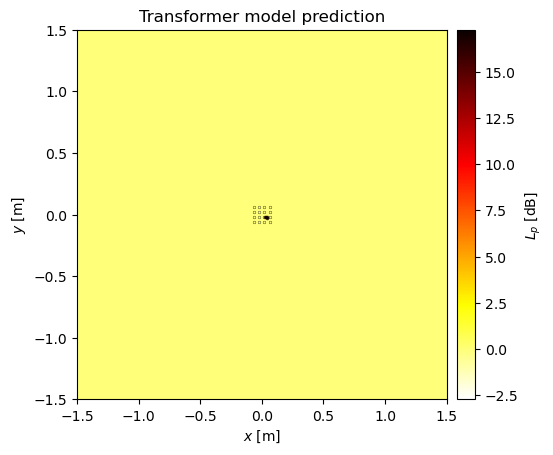

In [8]:
from pathlib import Path
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

# model_dir = '/home/rabea/Documents/Bachelorarbeit/models/EigmodeTransformer_learning_rate0.00025_weight_decay1e-06_epochs500_2024-10-16_16-51'
# model_config_path = model_dir + '/config.toml'
# ckpt_path = model_dir + '/ckpt/best_ckpt/0187-1.09.keras'
FREQ = 4000 #Hz

micgeom_path = Path(ac.__file__).parent / 'xml' / 'minidsp_uma-16_mirrored.xml'
mics = ac.MicGeom(from_file=micgeom_path)

ref_mic_index = 0

# load the machine learning model
model = tf.keras.models.load_model(ckpt_path)

devices = sd.query_devices()

for index, device in enumerate(devices):
    if "nanoSHARC micArray16 UAC2.0" in device['name']:
        device_index = index
        print(f"\nAusgewähltes Eingabegerät: {device['name']} bei Index {device_index}\n")
        break
else:
    print("Kein geeignetes Eingabegerät gefunden.")

sd.default.device = device_index 


source = ac.TimeSamples(name=sample_filename)
samplerate = sd.default.samplerate

# microphone geometry
mics = ac.MicGeom(from_file=micgeom_path)
csm_block_size = 128

# calculate the CSM from the incoming data
freq_data = ac.PowerSpectra(
    time_data=source, 
    block_size=csm_block_size, 
    window='Hanning'
    )

f_ind = np.argmin(np.abs(freq_data.fftfreq() - FREQ))
idx = f_ind

def preprocess_csm(csm):
    """ Preprocess the CSM data
    """
    neig = 8
    evls, evecs = np.linalg.eigh(csm)
    eigmode = evecs[..., -neig:] * evls[:, np.newaxis, -neig:]
    eigmode = np.stack([np.real(eigmode), np.imag(eigmode)], axis=3)
    eigmode = np.transpose(eigmode, [0, 2, 1, 3])
    input_shape = np.shape(eigmode)
    eigmode = np.reshape(eigmode, [-1, input_shape[1], input_shape[2]*input_shape[3]])
    return eigmode, csm_norm


csm = freq_data.csm[:,:,:]
# normalize the CSM
csm_norm = csm[:,0,0]
csm = csm / csm_norm[:, np.newaxis, np.newaxis]

csm=csm[idx][np.newaxis]

eigmode, csm_norm2 = preprocess_csm(csm)
print(eigmode.shape, eigmode.mean(), eigmode)
# make prediction
strength_pred, loc_pred, noise_pred = model.predict(eigmode)
strength_pred = strength_pred.squeeze()
strength_pred *= np.real(csm_norm)[idx]
loc_pred = recover_loc(loc_pred.squeeze(), aperture=mics.aperture, shift_loc=True, norm_loc=2) 
print(loc_pred)

# recover absolute location

# plot the results
fig, ax = plt.subplots()
ax.set_title("Transformer model prediction")
vmax = ac.L_p(strength_pred).max()
vmin = vmax - 20 # 20 dB dynamic range
norm = matplotlib.colors.Normalize(vmax=vmax,vmin=vmin)
color = matplotlib.pyplot.get_cmap('hot_r')(norm(ac.L_p(strength_pred)))
im = ax.imshow(np.zeros((64,64)), origin='lower', extent=(-1.5, 1.5, -1.5, 1.5), cmap='hot_r', vmax=vmax, vmin=vmin)
c = plt.colorbar(im, ax=ax, label=r'$L_{p}$ [dB]',pad=0.02, shrink=1,)
ax.set_xlabel(r'$x$ [m]')
ax.set_ylabel(r'$y$ [m]')
# plot microphone array as unfilled circles
for m in mics.mpos.T:
    ax.plot(m[0], m[1], 'ko', markersize=2., markeredgewidth=0.25, fillstyle='none')
# plot predicted locations
for s in range(loc_pred.shape[1]):
    if ac.L_p(strength_pred)[s] > 0:
        ax.plot(loc_pred[0,s], loc_pred[1,s], 'o', markersize=2.5, alpha=0.8, markeredgewidth=0, color=color[s])



In [ ]:
FREQ = 4000 